<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
!nvidia-smi
!nvcc -V

Mon Mar 20 10:03:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8     8W /  30W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [2]:
# Basic python libraries.
import datetime
import numpy as np
import os
import tensorflow
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries.
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

print('Above libraries have been imported.')

Above libraries have been imported.


**Seperate the Training and Validation Data.**

In [3]:
# Define the train and validataion data paths.
train_dir = '../../dataset/train'
val_dir = '../../dataset/val'

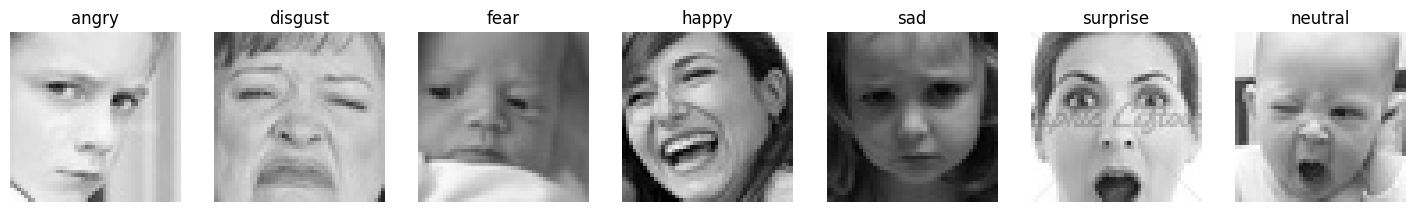

In [4]:
# Define the default image size.
img_size = 48

# Define the seven emotions provided in dataset.
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Plot the images with each distinct emotions.
plt.figure(figsize=(18,22))
i = 1
for expression in emotion_list:
    img = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[59]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

**Have a look at our data.**

**Perform some Data Augmentation on train and validations sets.**

In [5]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    # SOURCE: https://jkjung-avt.github.io/keras-image-cropping/
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

# **Data Preprocessing:**

In [6]:
# Rescale the data.
'''
Before we proceed we need to rescale our data by multiplying it to 1/255.
This is done so we get target values between 0 and 1.
'''
# Rescale train data.
datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale validation data.
datagen_val = ImageDataGenerator(rescale = 1./255,
                                 )

print('Above data generator functions have been created.')

Above data generator functions have been created.


In [7]:
# Perform data augmentation.
'''
Data augmentation is a technique to artificially create new training data from existing training data. 
It helps us to increase the size of the dataset and introduce variability in the dataset.
'''
# Define the default image size.
img_size = 48

# Define batch size.
batch_size = 32

                                         
# Train data
train_set = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation data
val_set = datagen_train.flow_from_directory(
    directory=val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


print('Train and Validation sets have been created.')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train and Validation sets have been created.


**Now lets create our custom CNN model.**

# **Build CNN Model:**

**Before we start building the neural network lets understand some of the terms that we will be using.**

* **Model = sequential** : A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

* **Padding** = The padding parameter of the Keras Conv2D class can take one of two values: 'valid' or 'same'. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

* **Activation** = relu :The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

* **Maxpooling** = Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling.

* **Batch normalization** = Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

* **Dropout** = Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

* **Adam** = Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [8]:
# Learning rate config per the He et al. paper
boundaries = [32000, 48000]
values = [0.1, 0.01, 0.001]
lr_schedule = schedules.PiecewiseConstantDecay(boundaries, values)

loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define optimizer
optimizer_momentum = 0.9
optimizer_additional_metrics = ["accuracy"]
optimizer = SGD(learning_rate=lr_schedule, momentum=optimizer_momentum)


In [9]:
class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes, dropout_rate=0.5):
    super().__init__()

    self.add(Conv2D(64, kernel_size = (3,3),
                    strides= 2, 
                    padding = 'valid', 
                    activation = 'relu',
                    input_shape= input_shape,
                    kernel_initializer= 'he_normal'
                    ))
    
    self.add(MaxPooling2D(pool_size=(3,3), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None))
    

    self.add(Conv2D(128, kernel_size=(3,3), 
                    strides= 1,
                    padding= 'same', 
                    activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    self.add(MaxPooling2D(pool_size=(3,3), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None)) 


    self.add(Conv2D(256, kernel_size=(3,3), 
                    strides= 1,
                    padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

    self.add(MaxPooling2D(pool_size=(2,2), 
                          strides= (2,2),
                          padding= 'valid', 
                          data_format= None))


    self.add(Flatten())
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dropout(dropout_rate))
    self.add(Dense(num_classes, activation= 'softmax'))

    opt = SGD(lr=0.01)
    self.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
model = AlexNet((48,48,3),7)

epochs = 200
steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = val_set.n//val_set.batch_size

history = model.fit(train_set,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              batch_size = 128, 
                              validation_data=val_set,
                              validation_steps=validation_steps,
                            )

Epoch 1/200
897/897 [==============================] - 224s 240ms/step - loss: 1.8186 - accuracy: 0.2452 - val_loss: 1.7782 - val_accuracy: 0.2577
Epoch 2/200
897/897 [==============================] - 34s 38ms/step - loss: 1.7719 - accuracy: 0.2729 - val_loss: 1.7273 - val_accuracy: 0.3108
Epoch 3/200
897/897 [==============================] - 34s 37ms/step - loss: 1.7146 - accuracy: 0.3149 - val_loss: 1.6544 - val_accuracy: 0.3559
Epoch 4/200
897/897 [==============================] - 34s 38ms/step - loss: 1.6554 - accuracy: 0.3477 - val_loss: 1.6099 - val_accuracy: 0.3722
Epoch 5/200
897/897 [==============================] - 34s 38ms/step - loss: 1.6036 - accuracy: 0.3734 - val_loss: 1.5511 - val_accuracy: 0.4043
Epoch 6/200
897/897 [==============================] - 35s 38ms/step - loss: 1.5639 - accuracy: 0.3917 - val_loss: 1.5551 - val_accuracy: 0.3954
Epoch 7/200
897/897 [==============================] - 34s 38ms/step - loss: 1.5236 - accuracy: 0.4127 - val_loss: 1.4670 - val_

897/897 [==============================] - 36s 40ms/step - loss: 1.0063 - accuracy: 0.6207 - val_loss: 1.1690 - val_accuracy: 0.5646
Epoch 58/200
897/897 [==============================] - 35s 38ms/step - loss: 1.0017 - accuracy: 0.6220 - val_loss: 1.1692 - val_accuracy: 0.5681
Epoch 59/200
897/897 [==============================] - 38s 42ms/step - loss: 1.0010 - accuracy: 0.6219 - val_loss: 1.1566 - val_accuracy: 0.5667
Epoch 60/200
897/897 [==============================] - 38s 43ms/step - loss: 0.9914 - accuracy: 0.6233 - val_loss: 1.1462 - val_accuracy: 0.5763
Epoch 61/200
897/897 [==============================] - 36s 40ms/step - loss: 0.9830 - accuracy: 0.6296 - val_loss: 1.1564 - val_accuracy: 0.5746
Epoch 62/200
897/897 [==============================] - 34s 38ms/step - loss: 0.9813 - accuracy: 0.6302 - val_loss: 1.1430 - val_accuracy: 0.5798
Epoch 63/200
897/897 [==============================] - 35s 39ms/step - loss: 0.9761 - accuracy: 0.6336 - val_loss: 1.1294 - val_accuracy

#Save model

In [39]:
model_dir = "AlexNetnew_model_200.h5"
model_weights_dir = "AlexNetnew_model_weighs_200.h5"

In [40]:
# Save the whole model
model.save(model_dir)
model.save_weights(model_weights_dir)

In [ ]:
checkpoint_path = "model_weights/AlexNetnew_model_weighs_100.h5"
model_loaded = AlexNet((48,48,3),7)
model_loaded.load_weights(checkpoint_path)

history = model_loaded.fit_generator(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=100,
    validation_data=val_set,
    validation_steps=len(val_set)
)

In [ ]:
model_weights_dir = "AlexNetnew_model_weighs_200.h5"
model_loaded.save_weights(model_weights_dir)

# **Model evaluation:**

In [ ]:
# Using Tensorboard 
%tensorboard --logdir logs/fit

In [ ]:
# Or using plotting 
# Create plots for accuracy and loss.
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Create confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

# Create function to plot confussion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

## Pretrain Model


Load model:

loaded_model = load_model("AlexNet_model-100iters.h5")
loaded_model.load_weights("AlexNet_model_weights-100iters.h5")